# Introduction

This Kernel objective is to explore the dataset for SSIM-ISIC Melanoma Classification Challenge.  

The images are provided in DICOM format. These images are in the original format from the radiological scanner output, with high resolution, lossless compression.

Images are also provided in JPEG and TFRecord format (in the jpeg and tfrecords directories, respectively). 

Metadata is also provided outside of the DICOM format, in CSV files. 

We will explore both the metadata in DICOM format and in the CSV files.

# Prepare for data exploration

## Load packages

In [7]:
import pandas as pd 
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import pydicom as dcm
import seaborn as sns
%matplotlib inline 
PATH = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"

## Load the Data

Let's load the tabular data. There are three files:

* Sample submission;  
* Train;  
* Test.  

In [8]:
sample_submission_df = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))
train_df = pd.read_csv(os.path.join(PATH,'train.csv'))
test_df = pd.read_csv(os.path.join(PATH,'test.csv'))

In [9]:
print(f"sample submission shape: {sample_submission_df.shape}")
print(f"train shape: {train_df.shape}")
print(f"test shape: {test_df.shape}")

sample submission shape: (10982, 2)
train shape: (33126, 8)
test shape: (10982, 5)


In [10]:
sample_submission_df.head()

image_name  target
0  ISIC_0052060       0
1  ISIC_0052349       0
2  ISIC_0058510       0
3  ISIC_0073313       0
4  ISIC_0073502       0

In [11]:
train_df.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [12]:
test_df.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

Test and sample submission csv files have 10982 rows (samples).  

In train data there are 3 columns not present either in test or in sample submission csv. These columns are:

* diagnosis;  
* bening_malignant;  
* target.  

The objective is to predict the probability (target) that the sample is malignant. 

Let's check now the train data in train and test folders.

In [7]:
train_image_list = os.listdir(os.path.join(PATH, 'train'))
test_image_list = os.listdir(os.path.join(PATH, 'test'))

print(f"train image_name list: {train_df.image_name.nunique()}")
print(f"train image list: {len(train_image_list)}")
print(f"test image_name list: {test_df.image_name.nunique()}")
print(f"test image list: {len(test_image_list)}")

train image_name list: 33126
train image list: 33126
test image_name list: 10982
test image list: 10982


## Missing data


Let's check for missing data in the images list.

In [8]:
trimmed_train_image_list = []
for img in train_image_list:
    trimmed_train_image_list.append(img.split('.dcm')[0])
    
trimmed_test_image_list = []
for img in test_image_list:
    trimmed_test_image_list.append(img.split('.dcm')[0])  

In [9]:
intersect_train_train = (set(train_df.image_name.unique()) & set(trimmed_train_image_list))
intersect_test_test = (set(test_df.image_name.unique()) & set(trimmed_test_image_list))

print(f"image train (dcm) & train csv: {len(intersect_train_train)}")
print(f"image test (dcm) & test csv: {len(intersect_test_test)}")

image train (dcm) & train csv: 33126
image test (dcm) & test csv: 10982


# Data exploration


Let's explore the distribution of the data.

We start with the distribution of patient id's.

In [10]:
tr_patient_id = train_df.patient_id.nunique()
te_patient_id = test_df.patient_id.nunique()
list_tr_patient_id = train_df.patient_id.unique()
list_te_patient_id = test_df.patient_id.unique()
intersection = set(list_tr_patient_id) & set(list_te_patient_id)
print(f"Unique patients in train: {tr_patient_id} and test: {te_patient_id}")
print(f"Patients in common in train and test: {len(intersection)}")

Unique patients in train: 2056 and test: 690
Patients in common in train and test: 0


Let's group the images per patient to see what is the distribution of images per patient.

In [11]:
tmp = train_df.groupby(['patient_id', 'target'])['image_name'].count()
tr_df = pd.DataFrame(tmp).reset_index(); tr_df.columns = ['patient_id', 'target', 'images']

tmp = test_df.groupby(['patient_id'])['image_name'].count()
te_df = pd.DataFrame(tmp).reset_index(); te_df.columns = ['patient_id', 'images']


tr_df.head()

patient_id  target  images
0  IP_0001230       0       6
1  IP_0019713       0      13
2  IP_0036322       0       5
3  IP_0038436       0       3
4  IP_0038545       0      27

In [12]:
te_df.head()

patient_id  images
0  IP_0013292       9
1  IP_0015264       6
2  IP_0018862       8
3  IP_0019804      11
4  IP_0035173       6

<Figure size 432x288 with 0 Axes>

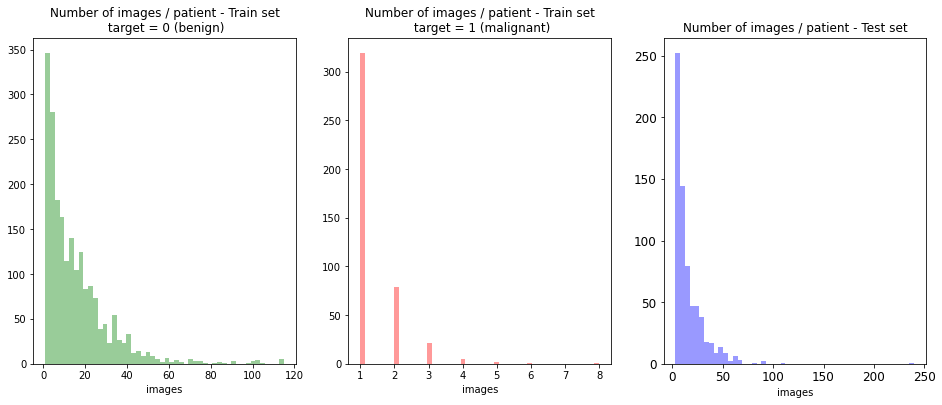

In [13]:
plt.figure()
fig, ax = plt.subplots(1,3,figsize=(16,6))
g_tr0 = sns.distplot(tr_df.loc[tr_df.target==0, 'images'],kde=False,bins=50, color="green",label='target = 0', ax=ax[0])
g_tr1 = sns.distplot(tr_df.loc[tr_df.target==1, 'images'],kde=False,bins=50, color="red",label='target = 1', ax=ax[1])
g_te = sns.distplot(te_df['images'],kde=False,bins=50, color="blue", label='columns', ax=ax[2])
g_tr0.set_title('Number of images / patient - Train set\n target = 0 (benign)')
g_tr1.set_title('Number of images / patient - Train set\n target = 1 (malignant)')
g_te.set_title('Number of images / patient - Test set')

locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

We can observe that the numberof images / patient in the case of malignant cases have a more compact distribution, maximum number of images / patient being 8, while in the case of patients with the result of exam benign the total number of images / patient might be up to 120. Of course, also in the case of patients with benign diagnosis the majority of cases will have just few images. In the same time, we can most probably conclude that the number of images / patient might be a good predictor for the value of target if the number of images is large. 


In [14]:
def plot_count(df, feature, title='', size=2, rotate_axis = False):
    f, ax = plt.subplots(1,1, figsize=(3*size,2*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='Set3')
    plt.title(title)
    if(rotate_axis):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

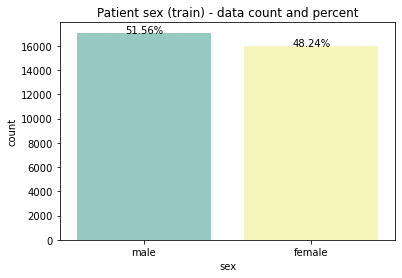

In [15]:
plot_count(train_df, 'sex', 'Patient sex (train) - data count and percent')

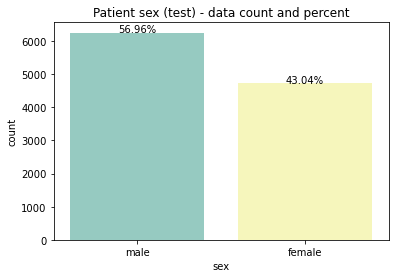

In [16]:
plot_count(test_df, 'sex', 'Patient sex (test) - data count and percent')

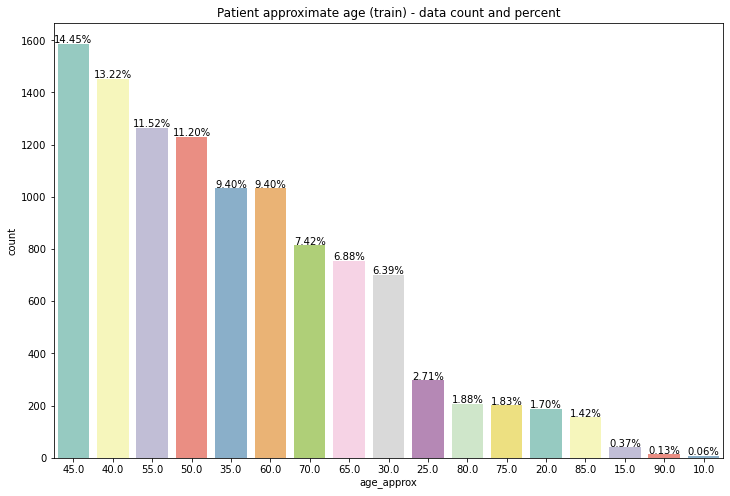

In [17]:
plot_count(test_df, 'age_approx', 'Patient approximate age (train) - data count and percent', size=4)

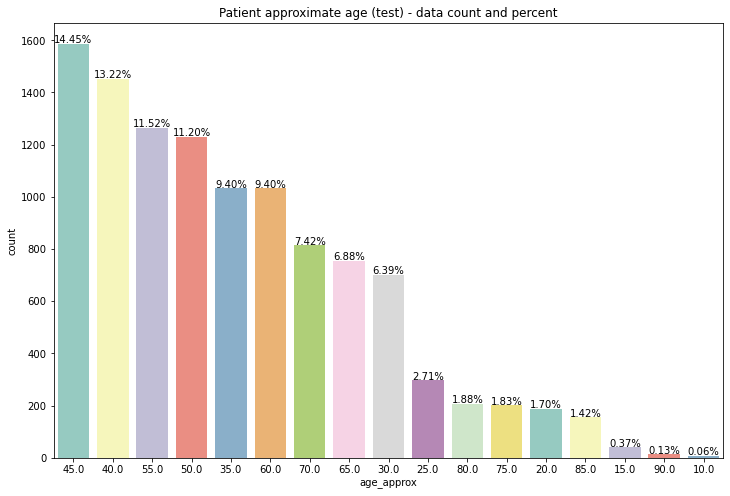

In [18]:
plot_count(test_df, 'age_approx', 'Patient approximate age (test) - data count and percent', size=4)

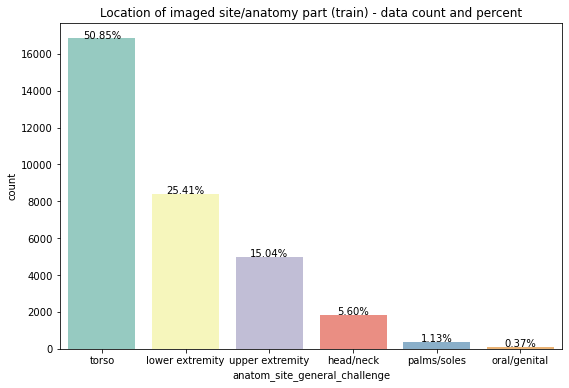

In [19]:
plot_count(train_df, 'anatom_site_general_challenge', 'Location of imaged site/anatomy part (train) - data count and percent', size=3)

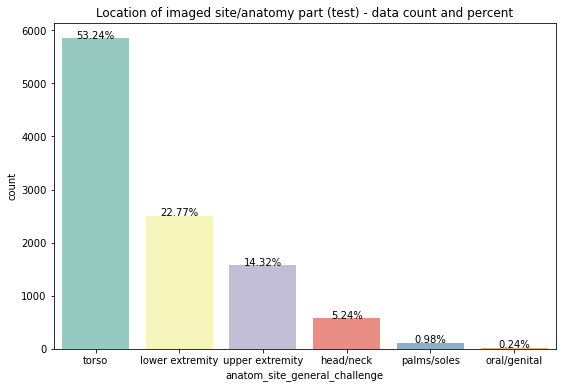

In [20]:
plot_count(test_df, 'anatom_site_general_challenge', 'Location of imaged site/anatomy part (test) - data count and percent', size=3)

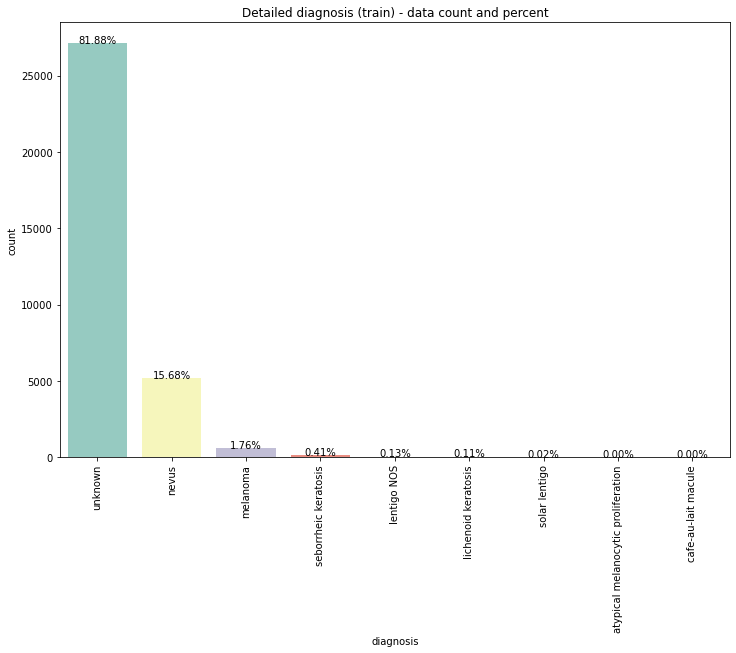

In [21]:
plot_count(train_df, 'diagnosis', 'Detailed diagnosis (train) - data count and percent', size=4, rotate_axis=True)

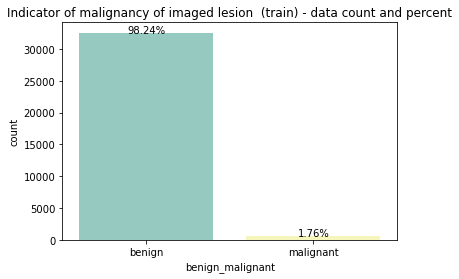

In [22]:
plot_count(train_df, 'benign_malignant', 'Indicator of malignancy of imaged lesion  (train) - data count and percent')

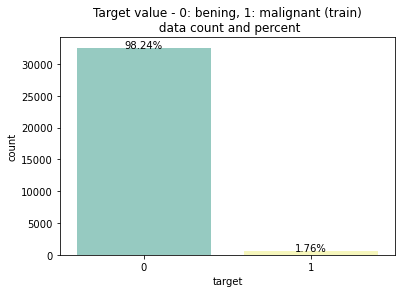

In [23]:
plot_count(train_df, 'target', 'Target value - 0: bening, 1: malignant (train)\n data count and percent')

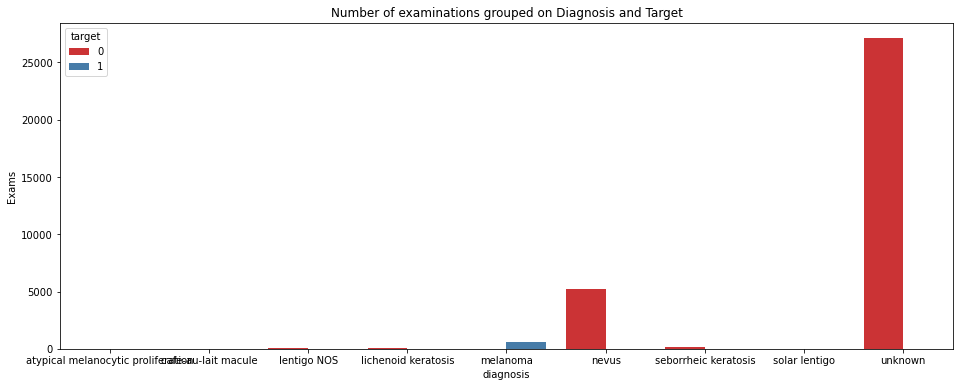

In [24]:
fig, ax = plt.subplots(nrows=1,figsize=(16,6)) 
tmp = train_df.groupby('diagnosis')['target'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'diagnosis', y='Exams',hue='target',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Diagnosis and Target") 
plt.show()

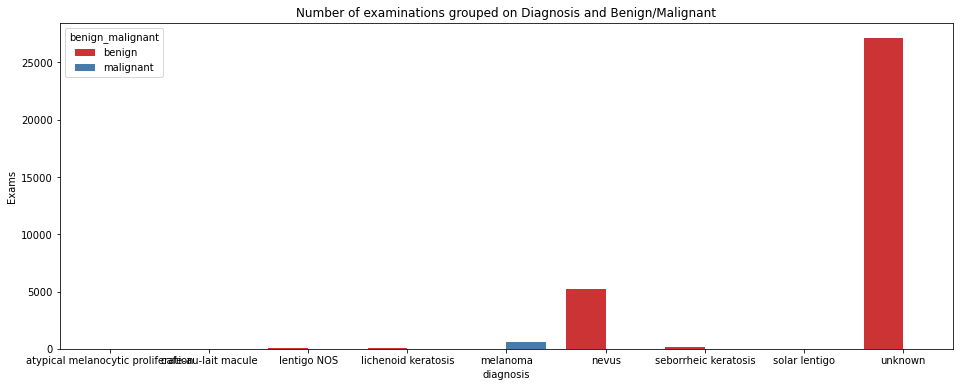

In [25]:
fig, ax = plt.subplots(nrows=1,figsize=(16,6)) 
tmp = train_df.groupby('diagnosis')['benign_malignant'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'diagnosis', y='Exams',hue='benign_malignant',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Diagnosis and Benign/Malignant") 
plt.show()

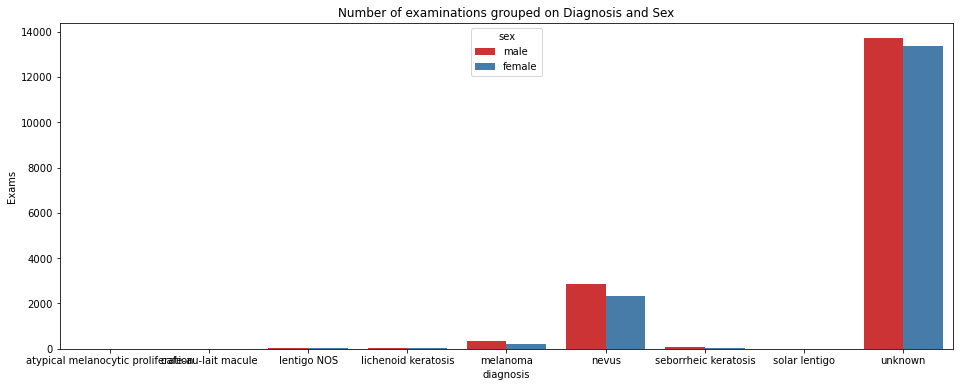

In [26]:
fig, ax = plt.subplots(nrows=1,figsize=(16,6)) 
tmp = train_df.groupby('diagnosis')['sex'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'diagnosis', y='Exams',hue='sex',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Diagnosis and Sex") 
plt.show()

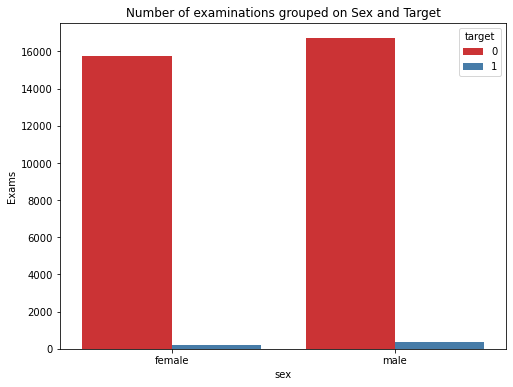

In [27]:
fig, ax = plt.subplots(nrows=1,figsize=(8,6)) 
tmp = train_df.groupby('sex')['target'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'sex', y='Exams',hue='target',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Sex and Target") 
plt.show()

In [28]:
def plot_distribution_grouped(feature, feature_group, hist_flag=True):
    fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
    for f in train_df[feature_group].unique():
        df = train_df.loc[train_df[feature_group] == f]
        sns.distplot(df[feature], hist=hist_flag, label=f)
    plt.title(f'Data/image {feature} distribution, grouped by {feature_group}')
    plt.legend()
    plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


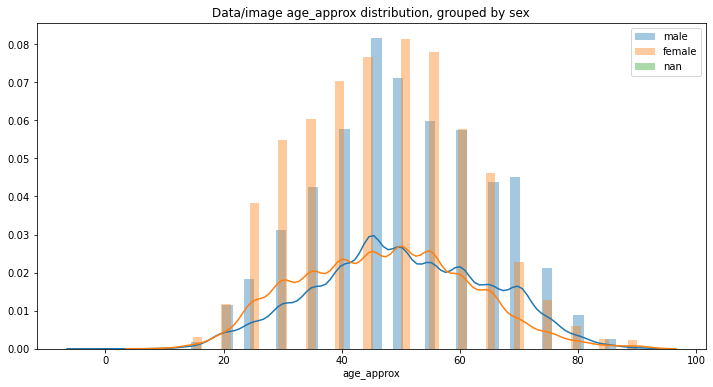

In [29]:
plot_distribution_grouped('age_approx', 'sex')

## Images samples


Let's visualize a part of the images, first from the training set.

We select only images corresponding to `target` = 1 (malignant).

In [30]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['image_name']+'.dcm'
        imagePath = os.path.join(PATH,"train/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.gray) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title(f"ID: {data_row['image_name']}\nModality: {modality} Age: {age} Sex: {sex}\nDiagnosis: {data_row['diagnosis']}")
    plt.show()

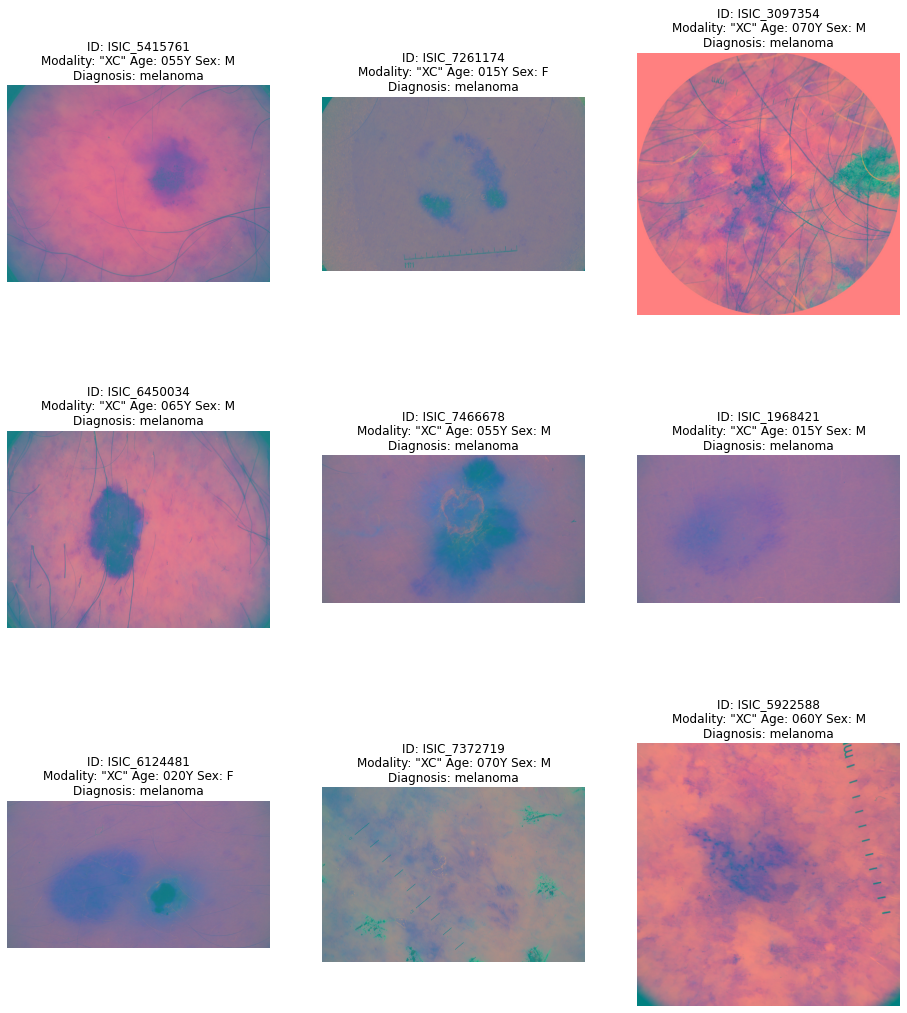

In [31]:
show_dicom_images(train_df[train_df['target']==1].sample(9))

Let's look now to few Dicom images with `target` = 0 (benign)

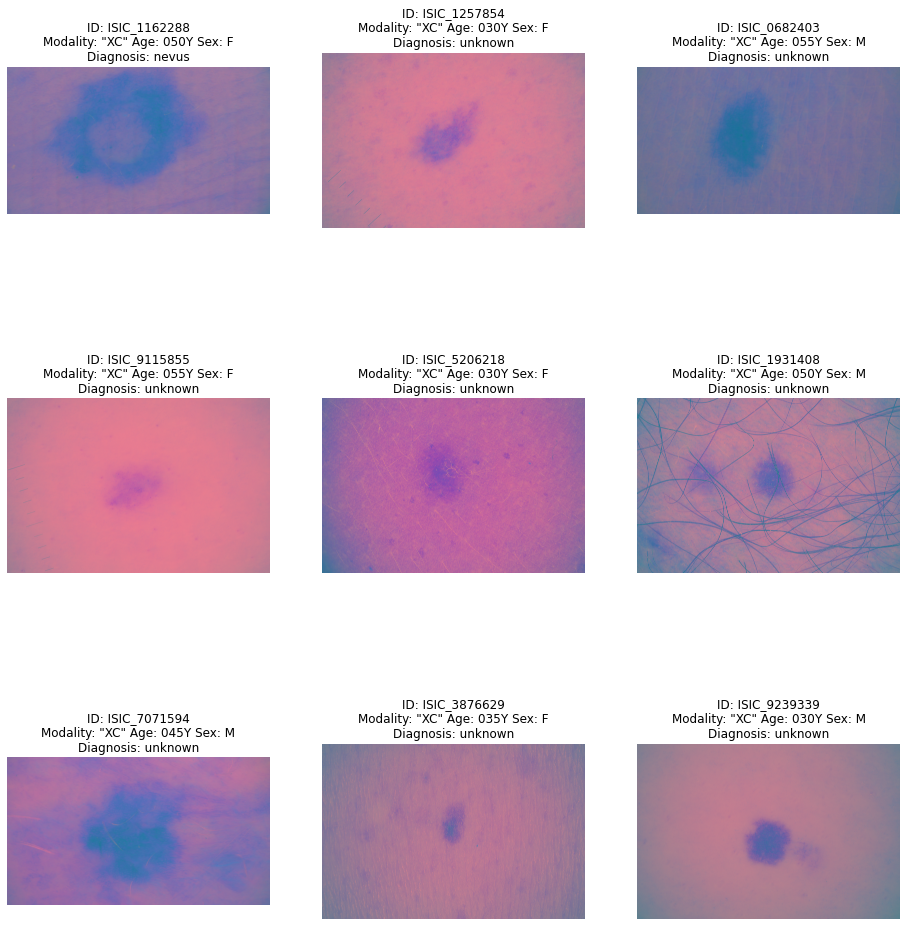

In [32]:
show_dicom_images(train_df[train_df['target']==0].sample(9))

Now let's select few images with diagnosis `melanoma`.

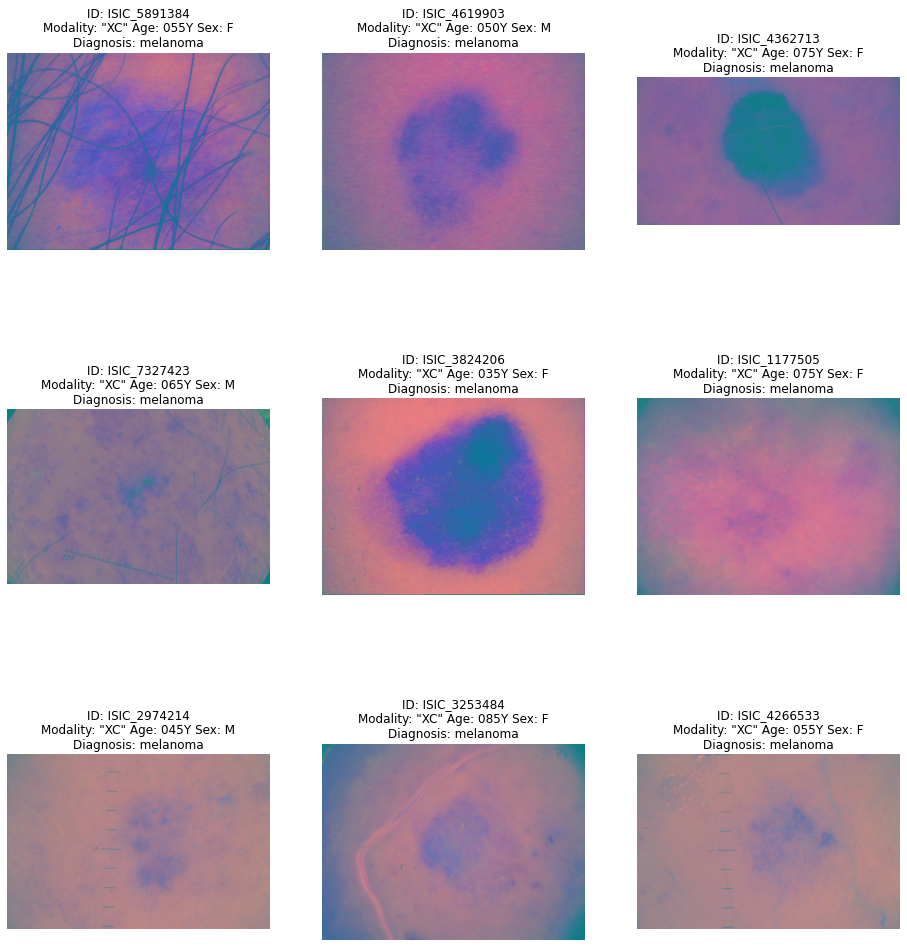

In [33]:
show_dicom_images(train_df[train_df['diagnosis']=='melanoma'].sample(9))

And now let's look to few different anatomic parts. Next, `head/neck`.

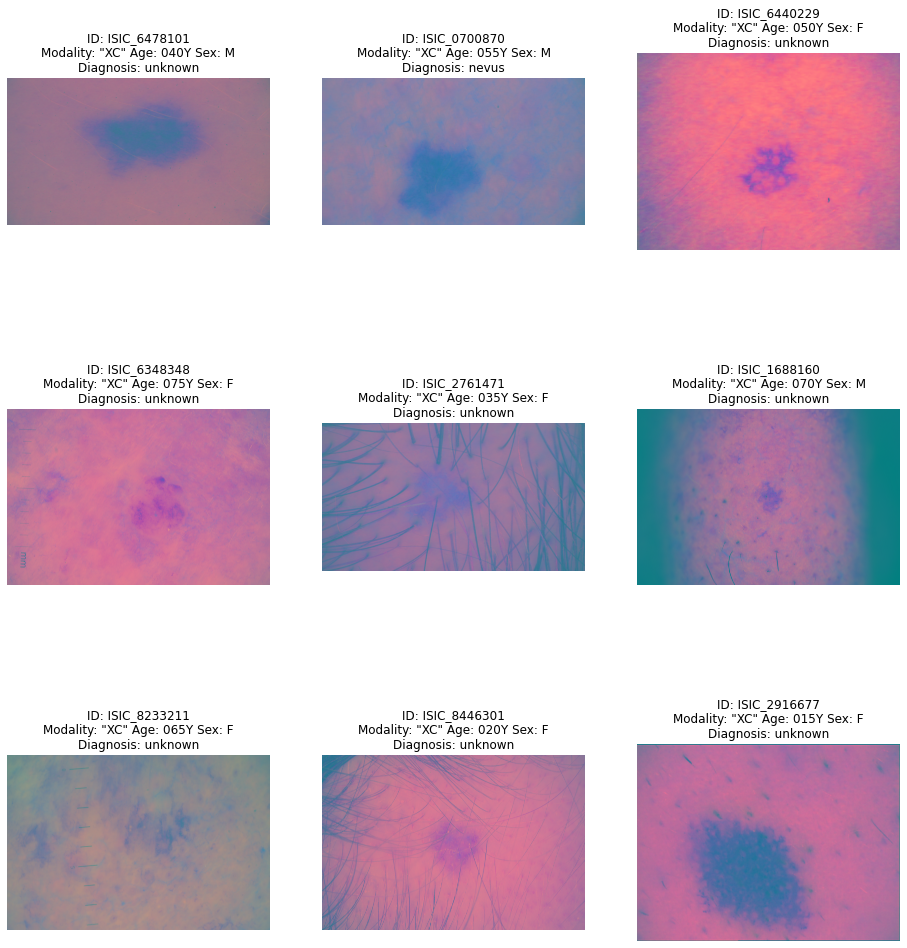

In [34]:
show_dicom_images(train_df[train_df['anatom_site_general_challenge']=='head/neck'].sample(9))

Let's look to anatomic part `torso`.

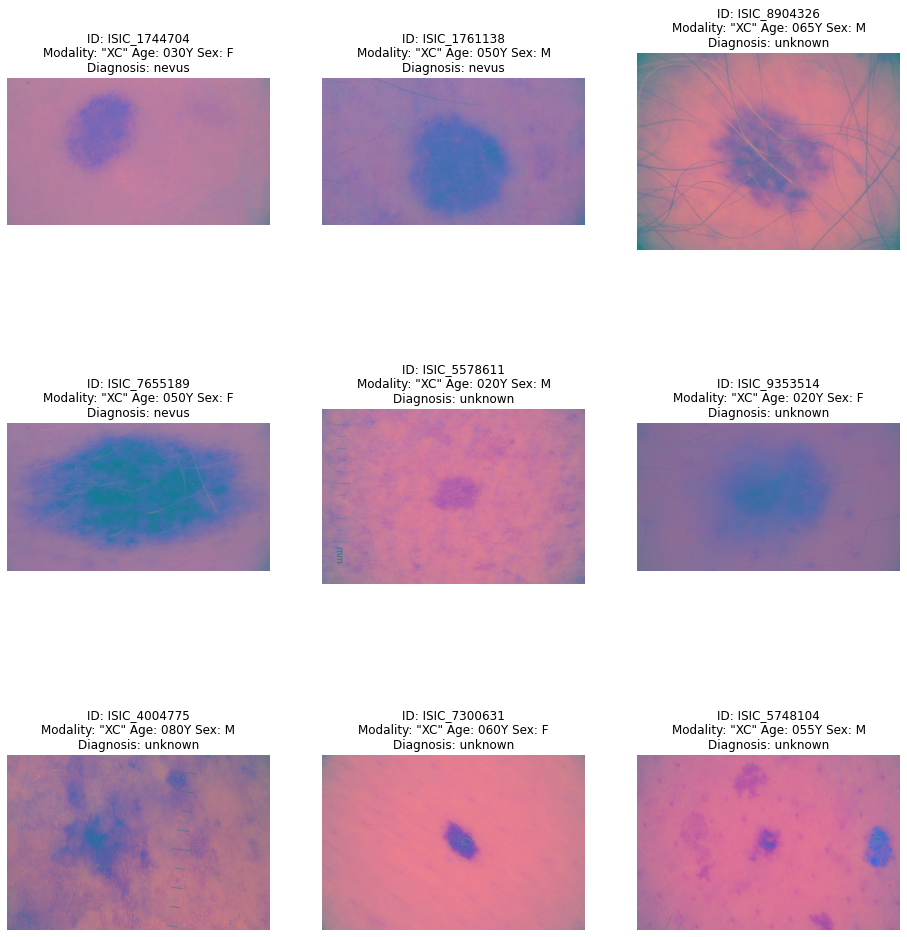

In [35]:
show_dicom_images(train_df[train_df['anatom_site_general_challenge']=='torso'].sample(9))

## Explore DICOM files


Let's look to more details from the DICOM files.

In [36]:
sample_item = list(train_df[:3].T.to_dict().values())[0]
sample_image_name = sample_item['image_name']
sample_patient_sex = sample_item['sex']
sample_patient_age = sample_item['age_approx']
body_part_examined = sample_item['anatom_site_general_challenge']
image_ID = sample_image_name +'.dcm'
dicom_file_path = os.path.join(PATH,"train/",image_ID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
print(sample_image_name, sample_patient_sex, sample_patient_age,body_part_examined)
dicom_file_dataset

ISIC_2637011 male 45.0 head/neck


(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.5962.99.1.7164.1026.1589854346616.1.1.0.0.0
(0008, 0020) Study Date                          DA: '20200519'
(0008, 0023) Content Date                        DA: '20200519'
(0008, 0030) Study Time                          TM: '021226'
(0008, 0033) Content Time                        TM: '021226'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: '"XC"'
(0008, 0070) Manufacturer                        LO: ''
(0008, 0080) Institution Name                    LO: 'ISDIS'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 1030) Study Description                   LO: 'ISIC 2020 Grand Challenge image'
(0008, 2218)  Anatomic R

We observe that the information in the .csv file are aligned with the information in the corresponding DICOM file.

Also, we can observe that the information in the DICOM file was correctly anonymized for the challenge.  

Even the `(0008, 1030) Study Description` is set to: `LO: 'ISIC 2020 Grand Challenge image'`

Visualy inspecting the potential additional useful data in the DICOM file, we can spot (at the first glance) such informations like:  rows, columns, modality, body part examined.


Let's create a function to extract key attributes from DICOM files.

In [37]:
def extract_DICOM_attributes(folder):
    images = list(os.listdir(os.path.join(PATH, folder)))
    df = pd.DataFrame()
    for image in images:
        image_name = image.split(".")[0]
        dicom_file_path = os.path.join(PATH,folder,image)
        dicom_file_dataset = dcm.read_file(dicom_file_path)
        study_date = dicom_file_dataset.StudyDate
        modality = dicom_file_dataset.Modality
        age = dicom_file_dataset.PatientAge
        sex = dicom_file_dataset.PatientSex
        body_part_examined = dicom_file_dataset.BodyPartExamined
        patient_orientation = dicom_file_dataset.PatientOrientation
        photometric_interpretation = dicom_file_dataset.PhotometricInterpretation
        rows = dicom_file_dataset.Rows
        columns = dicom_file_dataset.Columns
             
        df = df.append(pd.DataFrame({'image_name': image_name, 
                        'dcm_modality': modality,'dcm_study_date':study_date, 'dcm_age': age, 'dcm_sex': sex,
                        'dcm_body_part_examined': body_part_examined,'dcm_patient_orientation': patient_orientation,
                        'dcm_photometric_interpretation': photometric_interpretation,
                        'dcm_rows': rows, 'dcm_columns': columns}, index=[0]))
    return df

In [38]:
tr_df = extract_DICOM_attributes('train')
train_dicom_df = train_df.merge(tr_df, on='image_name')

In [39]:
train_dicom_df.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target dcm_modality dcm_study_date dcm_age  \
0   unknown           benign       0         "XC"       20200519    045Y   
1   unknown           benign       0         "XC"       20200519    040Y   
2     nevus           benign       0         "XC"       20200519    050Y   
3   unknown           benign       0         "XC"       20200519    045Y   
4   unknown           benign       0         "XC"       20200519    055Y   

  dcm_sex dcm_body_part_examined dcm_patient_orientation  \
0       M              HEAD/NECK                           
1       F        UPPER EXTREMITY                           
2       F        LOWER EXTREMITY                           
3       F              HEAD/NECK                           
4       F        UPPER EXTREMITY                           

  dcm_photometric_interpretation  dcm_rows  dcm_columns  
0                   YBR_FULL_422      4000         6000  
1                   YBR_FULL_422      4000         6000  
2                   YBR_FULL_422      1053         1872  
3                   YBR_FULL_422      1053         1872  
4                   YBR_FULL_422      4000         6000

In [40]:
te_df = extract_DICOM_attributes('test')
test_dicom_df = test_df.merge(te_df, on='image_name')

In [41]:
test_dicom_df.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_0052060  IP_3579794    male        70.0                           NaN   
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity   
2  ISIC_0058510  IP_7960270  female        55.0                         torso   
3  ISIC_0073313  IP_6375035  female        50.0                         torso   
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity   

  dcm_modality dcm_study_date dcm_age dcm_sex dcm_body_part_examined  \
0         "XC"       20200519    065Y       M                   SKIN   
1         "XC"       20200519    035Y       M        LOWER EXTREMITY   
2         "XC"       20200519    055Y       F                  TORSO   
3         "XC"       20200519    050Y       F                  TORSO   
4         "XC"       20200519    045Y       F        LOWER EXTREMITY   

  dcm_patient_orientation dcm_photometric_interpretation  dcm_rows  \
0                                           YBR_FULL_422      4000   
1                                           YBR_FULL_422      4000   
2                                           YBR_FULL_422      4000   
3                                           YBR_FULL_422      4000   
4                                           YBR_FULL_422      1080   

   dcm_columns  
0         6000  
1         6000  
2         6000  
3         6000  
4         1920

### Check rows and columns distribution

<Figure size 432x288 with 0 Axes>

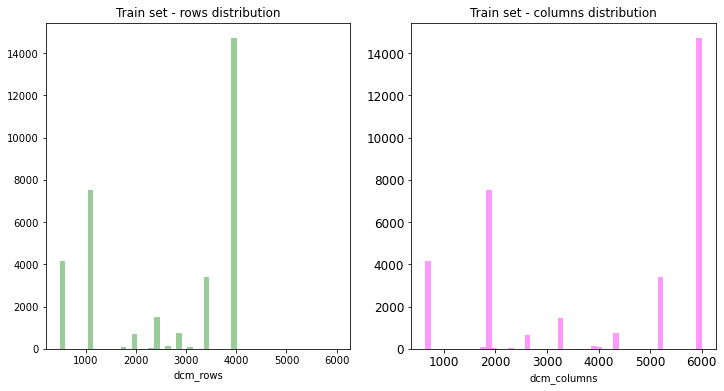

In [42]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,6))
g0 = sns.distplot(train_dicom_df['dcm_rows'],kde=False,bins=50, color="green",label='rows', ax=ax[0])
g1 = sns.distplot(train_dicom_df['dcm_columns'],kde=False,bins=50, color="magenta", label='columns', ax=ax[1])
g0.set_title('Train set - rows distribution')
g1.set_title('Train set - columns distribution')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

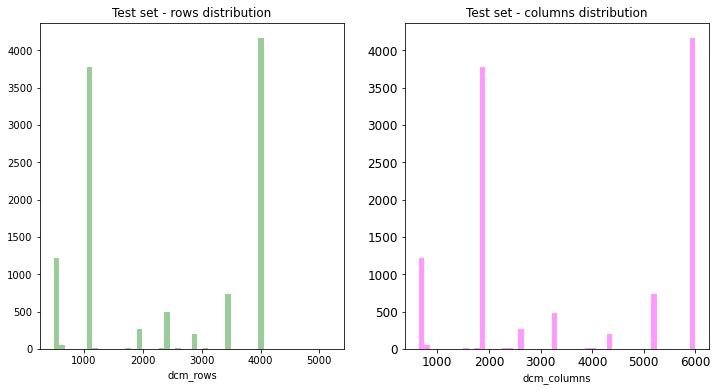

In [43]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,6))
g0 = sns.distplot(test_dicom_df['dcm_rows'],kde=False,bins=50, color="green",label='rows', ax=ax[0])
g1 = sns.distplot(test_dicom_df['dcm_columns'],kde=False,bins=50, color="magenta", label='columns', ax=ax[1])
g0.set_title('Test set - rows distribution')
g1.set_title('Test set - columns distribution')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()